```mermaid
flowchart LR

classDef notebook fill:#5c7fa6,stroke:#3f5a7b,color:#f2f6fb, font-weight:bold;
classDef python fill:#9a80b8,stroke:#6d5789,color:#f7f3fb, font-weight:bold;
classDef tools fill:#e9c48a,stroke:#b58950,color:#2d1c05;
classDef methods fill:#8cc7ab,stroke:#5e9475,color:#0f2f1f;

N05B["06_composites.ipynb"]:::notebook

N05B --> C1["composite_generator.py"]:::python

C1 --> T6["Tools:<br>polars (optional)<br>numpy<br>Pillow<br>os<br>random"]:::tools

T6 --> M6["Methods:<br>filter_images()<br>make_composite()<br>filter_faces()<br>generate_composite()"]:::methods


In [1]:
import os, sys

# 1) Set notebook working directory = FaceStats project root
PROJECT_ROOT = "/Users/jayklarin/__DI/Repositories/FaceStats"
os.chdir(PROJECT_ROOT)
print("cwd:", os.getcwd())

# 2) Add src/ folder to Python PATH
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

print("src path added:", SRC_PATH)


cwd: /Users/jayklarin/__DI/Repositories/FaceStats
src path added: /Users/jayklarin/__DI/Repositories/FaceStats/src


In [2]:
import pandas as pd

ATTR_PATH = 'data/processed/metadata/attributes_final.parquet'
ATTR_META = 'data/processed/metadata/attributes_with_meta.parquet'

attributes_final = pd.read_parquet(ATTR_PATH)

# Optional geometry-based attractiveness
try:
    df_meta = pd.read_parquet(ATTR_META)
    if 'attractiveness_geom' in df_meta.columns:
        attributes_final = attributes_final.merge(df_meta[['filename','attractiveness_geom']], on='filename', how='left')
except FileNotFoundError:
    pass

attributes_final.head()


Loaded: (700, 5)


,filename,age,gender_final,ethnicity_final,attractiveness
0,SFHQ_pt4_00001843.jpg,None,unknown,unknown,2.914631
1,SFHQ_pt4_00000591.jpg,None,male,white,2.938567
2,SFHQ_pt4_00002437.jpg,None,unknown,unknown,3.175124
3,SFHQ_pt4_00002345.jpg,None,unknown,unknown,3.208315
4,SFHQ_pt4_00003073.jpg,None,unknown,unknown,3.280991


#### Optional: filter by geometry-based attractiveness

In [ ]:
# Example filter by attractiveness_geom deciles (1–10)
if 'attractiveness_geom' in attributes_final.columns:
    geom_lo, geom_hi = 8, 10  # keep top deciles
    df_geom = attributes_final[(attributes_final['attractiveness_geom'] >= geom_lo) & (attributes_final['attractiveness_geom'] <= geom_hi)]
    print('Filtered rows:', len(df_geom))
else:
    df_geom = attributes_final
    print('attractiveness_geom not found; using full dataset')


[filter_faces] Strict filter returned 50 results.
[generate_composite] Filtered pool: 50 faces
[generate_composite] Sampling 25 faces


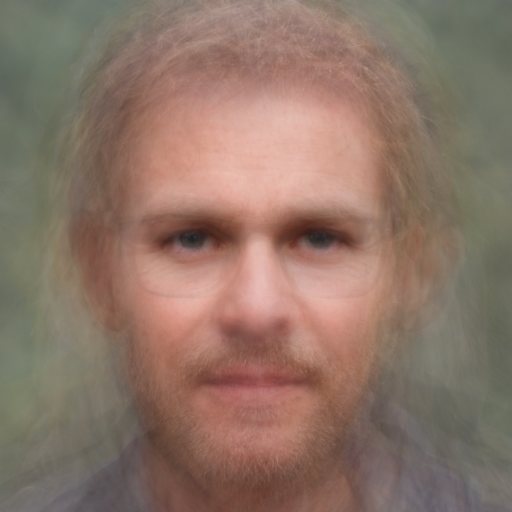

In [3]:
from composite.composite_generator import generate_composite

img = generate_composite(
    df=attributes_final,
    gender="male",
    ethnicity="white",
    attractiveness=[2.8, 3.8],   # replaces attr_min, attr_max
    sample_size=25,
    verbose=True
)
img


In [4]:
import pandas as pd

# Load final metadata (V4 path)
ATTR_PATH = "data/processed/metadata/attributes_final.parquet"

attributes_final = pd.read_parquet(ATTR_PATH)

print("Loaded attributes_final:", attributes_final.shape)
attributes_final.head()


Loaded attributes_final: (700, 5)


,filename,age,gender_final,ethnicity_final,attractiveness
0,SFHQ_pt4_00001843.jpg,None,unknown,unknown,2.914631
1,SFHQ_pt4_00000591.jpg,None,male,white,2.938567
2,SFHQ_pt4_00002437.jpg,None,unknown,unknown,3.175124
3,SFHQ_pt4_00002345.jpg,None,unknown,unknown,3.208315
4,SFHQ_pt4_00003073.jpg,None,unknown,unknown,3.280991


In [5]:
df = attributes_final  # your loaded metadata

print("Gender counts:")
display(df["gender_final"].value_counts(dropna=False))

print("\nEthnicity counts:")
display(df["ethnicity_final"].value_counts(dropna=False))

print("\nAge stats:")
display(df["age"].describe())


Gender counts:


gender_final
unknown    500
male       122
female      78
Name: count, dtype: int64


Ethnicity counts:


ethnicity_final
unknown                    500
white                       93
black                       31
east_or_southeast_asian     27
latino/hispanic             22
indian                      14
middle_eastern              13
Name: count, dtype: int64


Age stats:


count       0
unique      0
top       NaN
freq      NaN
Name: age, dtype: object